In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [71]:
file_path = 'filtered_weather_data.csv'
weather_data = pd.read_csv(file_path)


In [73]:
# Convert 'dt_iso' to datetime format to allow grouping by day
weather_data['dt_iso'] = pd.to_datetime(weather_data['dt_iso'], format='%m/%d/%Y %H:%M')

# Aggregate daily rainfall data
weather_data['date'] = weather_data['dt_iso'].dt.date
daily_rainfall = weather_data.groupby('date')['rain_1h'].sum().reset_index()
daily_rainfall['date'] = pd.to_datetime(daily_rainfall['date'])


In [75]:
# Normalize the rainfall data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
lstm_data = scaler.fit_transform(daily_rainfall['rain_1h'].values.reshape(-1, 1))

# Split data into 60% training, 20% validation, and 20% testing
train_size = int(len(lstm_data) * 0.6)
val_size = int(len(lstm_data) * 0.2)
test_size = len(lstm_data) - train_size - val_size

train_data = lstm_data[:train_size]
val_data = lstm_data[train_size:train_size + val_size]
test_data = lstm_data[train_size + val_size:]

In [77]:
# Define function to create dataset for LSTM
def create_dataset(data, time_step=30):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [79]:
# Create datasets
time_step = 30
X_train, Y_train = create_dataset(train_data, time_step)
X_val, Y_val = create_dataset(val_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)


In [81]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [83]:
# Build the optimized LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # First LSTM layer
model.add(Dropout(0.0))  # No dropout for first layer
model.add(LSTM(units=32, return_sequences=False))  # Second LSTM layer with 32 units
model.add(Dropout(0.3))  # 30% dropout for second layer
model.add(Dense(112))  # Dense layer with 112 units
model.add(Dense(1))  # Output layer

A:\Anacoda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [85]:
# Compile the LSTM model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), verbose=1)


Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0080 - val_loss: 0.0036
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 12/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 

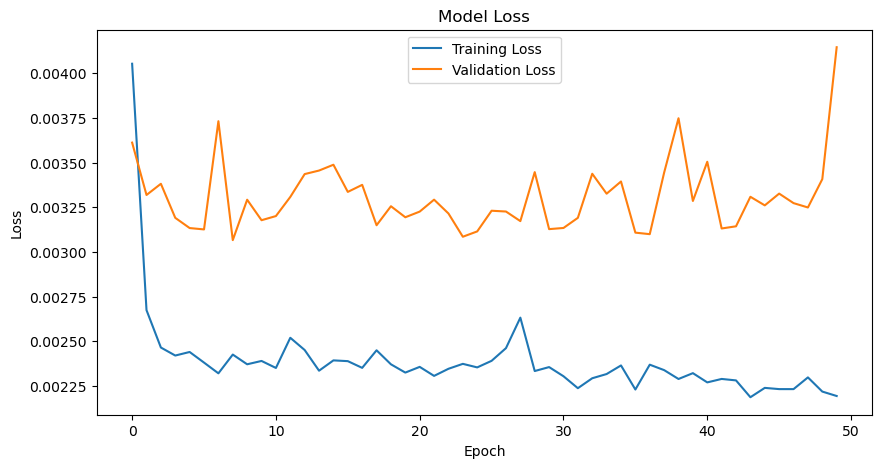

In [87]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
# Make predictions
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate error metrics for the optimized LSTM
mae_optimized_lstm = mean_absolute_error(Y_test, test_predict)
mse_optimized_lstm = mean_squared_error(Y_test, test_predict)
rmse_optimized_lstm = np.sqrt(mse_optimized_lstm)

print("LSTM - Mean Absolute Error (MAE):", mae_optimized_lstm)
print("LSTM - Mean Squared Error (MSE):", mse_optimized_lstm)
print("LSTM - Root Mean Squared Error (RMSE):", rmse_optimized_lstm)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM - Mean Absolute Error (MAE): 8.831013660258938
LSTM - Mean Squared Error (MSE): 451.97453033423153
LSTM - Root Mean Squared Error (RMSE): 21.2596926208784


In [91]:
# Set flood threshold
flood_threshold = 100  # Set threshold for flood-prone days

# Identify flood-prone days
dates = daily_rainfall['date'][train_size + time_step:train_size + time_step + len(test_predict)]
flood_days = pd.DataFrame({'date': dates, 'forecasted_rain': test_predict.flatten()})
flood_days['flood_warning'] = flood_days['forecasted_rain'] >= flood_threshold

# Display flood-prone days
predicted_flood_days = flood_days[flood_days['flood_warning'] == True]
print("\nPredicted flood days and forecasted rainfall (mm):")
print(predicted_flood_days[['date', 'forecasted_rain']])


Predicted flood days and forecasted rainfall (mm):
           date  forecasted_rain
5490 2015-01-12       132.688721
5696 2015-08-06       129.000397
5867 2016-01-24       115.931091
5887 2016-02-13       115.614731
6374 2017-06-14       231.103073
6553 2017-12-10       265.981934
6570 2017-12-27       314.374390


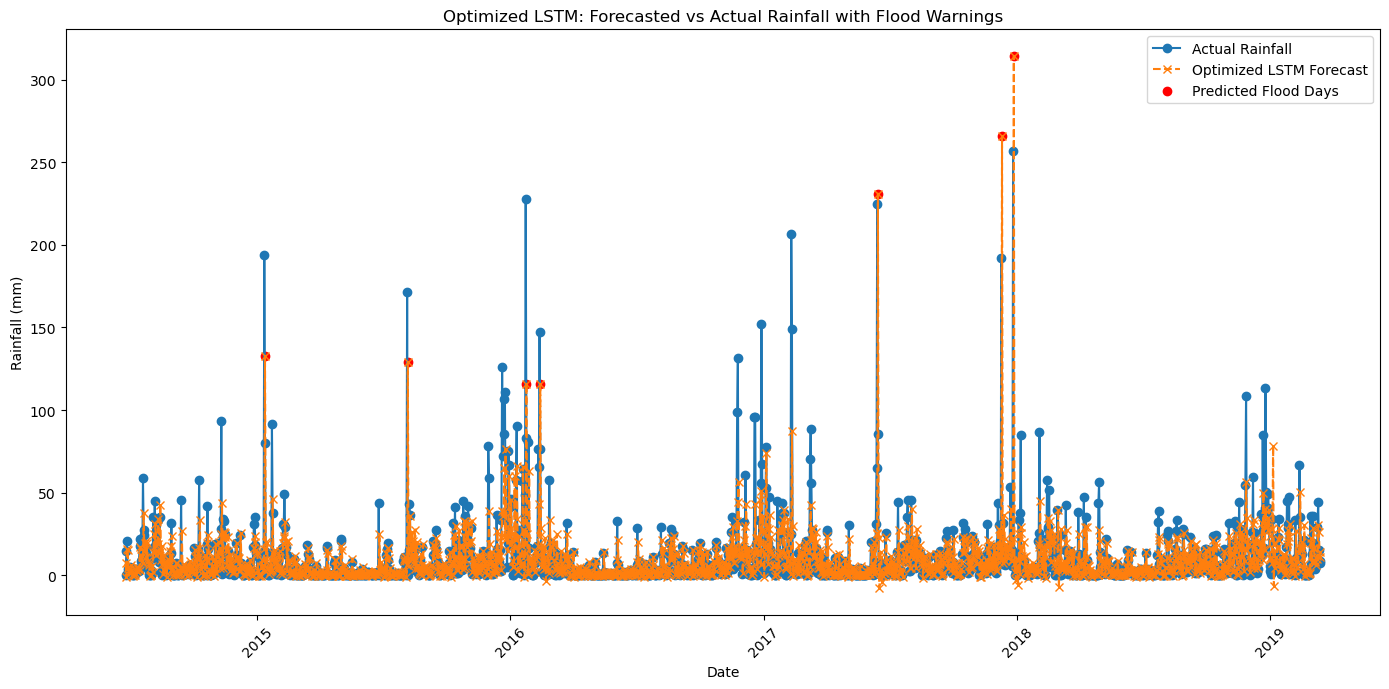

In [93]:
# Plot actual vs predicted rainfall with flood-prone days
plt.figure(figsize=(14, 7))
plt.plot(dates, Y_test.flatten(), label='Actual Rainfall', marker='o')
plt.plot(dates, test_predict.flatten(), label='Optimized LSTM Forecast', linestyle='--', marker='x')
plt.scatter(predicted_flood_days['date'], predicted_flood_days['forecasted_rain'], color='red', label='Predicted Flood Days')
plt.title("Optimized LSTM: Forecasted vs Actual Rainfall with Flood Warnings")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()